In [2]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import scipy.signal as sig
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0


# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')

%matplotlib widget

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Fundamentals of Sample Rate Conversion

* **Emne AIS2201 - Decimation**
* **Week 44, 2025**
* **Relevant Pensum:**
    * Chapter 10.1-10.6 in Understanding Digital Signal Processing
* **Lecturer: Kai Erik Hoff**

# What is sample rate conversion?

* Process of changing the sample rate of a discrete-time signal.

<img src="figures/sample_rate_conversion.png" align="center" style="width: 60%; margin-left:100px">


* **Goal:** *"Transform one digital stream of sampled data $x_{\text{old}}[n]$ sampled with sampling frequency $f_{s, \text{ old}}$ into a new signal $x_{\text{new}}[m]$ using sampling frequency $f_{s, \text{ new}}$, without compromising the spectral content of the signal."*

## Recap: Nyquist Sampling Theorem

* An analog signal $x(t)$ which does not contain frequency components of a frequency greater than $f_{\max}$ may represented in it´s entirety by a digital signal $x[n] = x(n\cdot T_s)$, provided the sampling frequency $f_s =\frac{1}{T_s}$ is greater than $2\cdot f_{max}$.

## $$f_s > 2\cdot f_{max} = \text{Nyquist rate}$$

* The maximum frequency which may be representeed by the digital signal $x[n]$,  $\frac{f_s}{2}$, is known as the *Nyquist Frequency*.

# Recap: Aliasing
* Aliasing occurse when the sampling theorem is **not** satisfied.

Output()

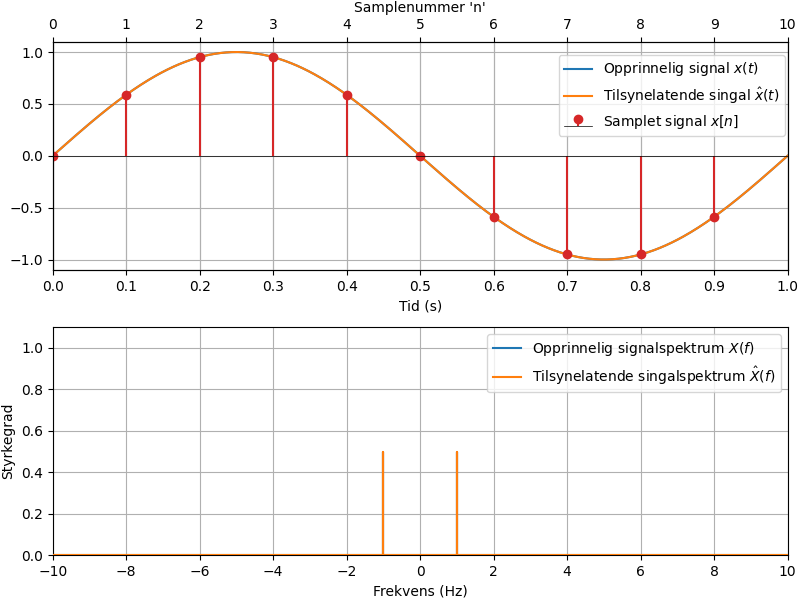

In [4]:
from demos import AliasingDemo2
AliasingDemo2(fig_num=3)

# Periodicity in the Frequency Domain



* Ambiguity of discrete-time sinusoids extends to any signal represented in the frequency domain

$$\Large X(\hat{\omega}) = X(\hat{\omega} + k \cdot 2\pi), \ \ \ k \in \mathbb{Z}$$

* The extended representation of a digital signal in the frequency domain gives periodic frequency content with period \$2\pi\$.


<!--
* Utvidet representasjon av et digitalt signal i frekvensdomenet gir periodisk frekvensinnhold der perioden er $2\pi$.
* Det båndbegrensede signalet får en serie ***spektrale kopier*** sentrert rundt $\hat{\omega} = k\cdot 2\pi$.
* Alle mulige spektrale kopier av et digitalt signal er "til stede" i signalets frekvensspekter.
    - Fourieranalyse av det digitale signalet vil gi utslag for alle disse kopiene
-->
<img src="figures/Fig10_SpectralSamling2.png" style="width: 90%">

* The band-limited signal produces a series of ***spectral copies*** centered around \$\hat{\omega} = k \cdot 2\pi\$.
* All possible spectral copies of a digital signal are potentially present in the signal’s frequency spectrum.
  * Fourier analysis of the digital signal will register all of these copies.

# Aliasing in the frequency domain

* Overlapping frequency components are added according to the phasor addition principle
    * Relative phase components will be practically randomized
    * Magnitudes can compund, cancel each other out, or anything between.
* Reversing the aliasing process not possible$^{*}$

<img src="figures/Fig12_SpectralAliasing2.png" style="width: 90%">

$^*$ unless we have some relevant prior knowledge about the signal to work with

# Anti-aliasing filter
* A safeguard is often needed to ensure no high-frequency interference can be picked up with aliasing
* An *analog* filter in advance of A/D conversion can be used to suppress signal components outside the nyquist range

<img src="figures/Fig16_AntiAliasing1.png" style="width: 80%; margin-left: 100px%">

# Part I: *Decimation*

* Follows much the same rules as A/D conversion
    * A/D converion can be viewed as reducing a signal´s sampling frequency from "infinite" to a finite value $f_s$
    * Decimation reduces a signal´s sampling frequency from $f_s$ to $\frac{f_s}{M}$

<img src="figures/downsampling.svg" align="center" style="width: 60%; margin-left:100px">

* Performed in $2$ stages: *decimation filter* followed by *downsampling*
    1. Decimation filtering commonly performed using a digital FIR filter
        * Serves similar role to an *anti-aliasing filter*
    3. Downsampling by an integer factor $M$ will retain only $1$ in $M$ samples

# Decimation example

* Code cell shows an example where a signal $x(t) = \sin(6 \pi \cdot t) + \cos(13\pi \cdot t)$ is sampled at a sampling frequency $f_s = 20$ samples per second, and then downsampled by a factor $M=2$.

In [19]:
def downsample(x, M):
    return x[::M]  # x_new[m]

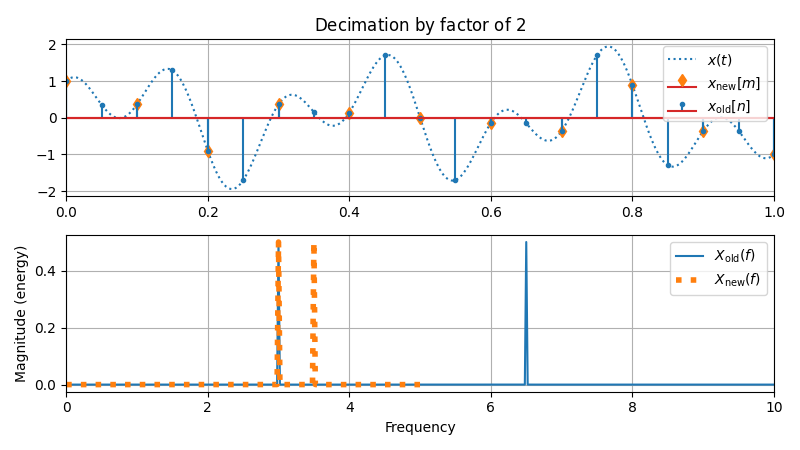

In [20]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
M = 2  # Decimation Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before decimation
t_m = t_n[::M]  # Sample times after decimation

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)
x_n = x(t_n)
x_m = downsample(x_n, M)

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x(t_n), Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x(t_m), Fs=fs//M, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Decimation by factor of ${M}$");

# Decimation Filter

* Before decimation, frequency components above $\frac{f_{s,\text{ new}}[n]}{2} = \frac{f_{s,\text{ old}}[n]}{2\cdot M}$ need to be suppressed.
* Below is shown an example filter for $M=2$

In [7]:
def design_lowpass(numtaps, # Number of filter taps
                   M):      # Decimation factor
    w_c = pi/M
    n = np.arange(numtaps)-(numtaps-1)/2
    h_n = w_c/pi*np.sinc(w_c/pi*n)*sig.windows.hamming(numtaps)
    return h_n

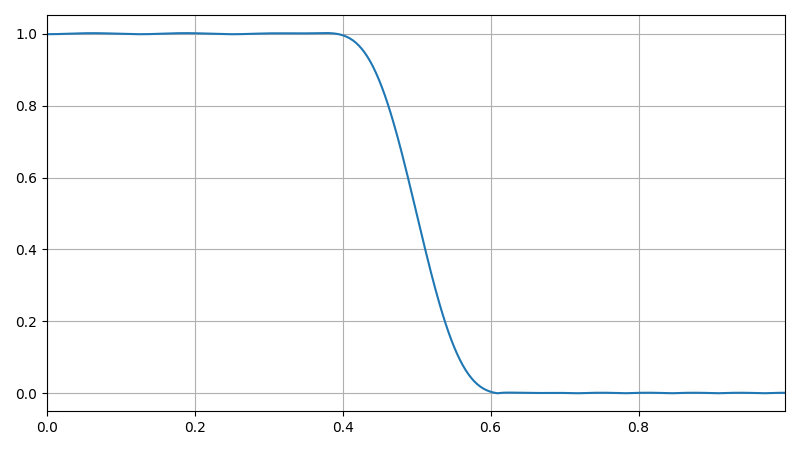

In [23]:
numtaps = 33
M = 2
h_n = design_lowpass(numtaps, M)
w, Hw = sig.freqz(h_n)
plt.figure()
plt.plot(w/np.pi, np.abs(Hw))

* Place the middle of the transition band on the new nyquist frequency $\frac{f_{s, \text{new}}}{2}$.
    * There will be aliasing, but only for frequencies $f > f_{\text{pass}}$

## Decimation example
* Code cell shows an example where a signal $x(t) = \sin(6 \pi \cdot t) + \cos(13\pi \cdot t)$ is sampled at a sampling frequency $f_s = 20$ samples per second, and then resampled to $f_{s, \text{ new}} = \frac{f_{s, \text{ old}}}{2}$.

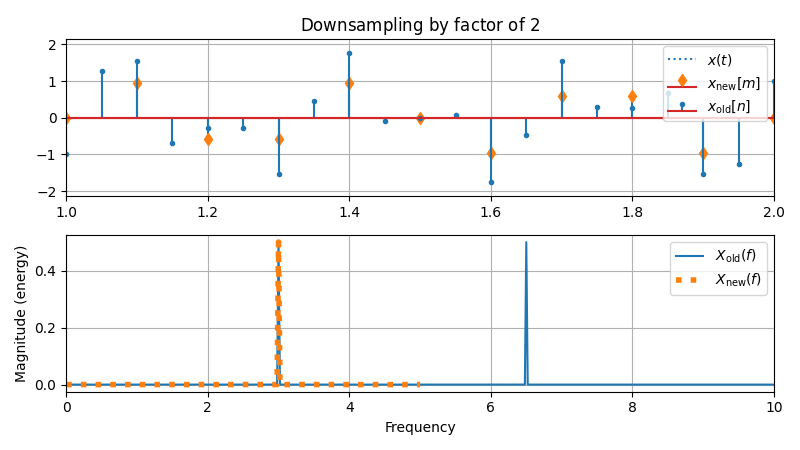

In [24]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
M = 2  # Decimation Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before decimation
t_m = downsample(t_n, M)  # Sample times after decimation

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)

x_n = x(t_n)
x_m = np.convolve(x_n, h_n, mode="same")
x_m = downsample(x_m, M)


plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim([1, 2])
ax[0].legend()
ax[1].magnitude_spectrum(x_n, Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x_m, Fs=fs//M, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Downsampling by factor of ${M}$");

## Decimation tricks

* Only $1$ in $M$ output samples actually need to be computed

* Can be done in multiple stages to save processing operations